<a href="https://colab.research.google.com/github/Tahahaha7/Quantitative_Trading/blob/main/Pairs_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Pair Trading}$

In [1]:
%%capture
!pip install yfinance

In [5]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [ ]:
!pip install statsmodels==0.12.2

In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import yfinance as yf

#Import other packages as you see fit

# Step 1: Find at least one pair

If you are struggling, there is code on how to do this sort of thing in the Quantopian notebook:
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

I recommend picking stocks from the same industry, like fast food or energy companies etc.

#### You should end up with a dataframe with the closing prices for a pair of stocks that were likely cointegrated in January 2018

In [8]:
#import data 
stocks = 'AAL', 'UAL', 'GOOG', 'AAPL', 'FB', 'TM', 'HMC', 'FORD', 'SNE', 'CMG', 'DIS', 'TWTR'

stock_data = yf.download(stocks, start='2018-01-01', end='2018-12-31', interval="1d")

[*********************100%***********************]  12 of 12 completed


In [9]:
#Find pair(s) code here

def find_cointegrated_pairs(data):
    '''
    Adopt Quantopian code to work on df columns
    '''
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    stocks = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[stocks[i]]
            S2 = data[stocks[j]]
            result = ts.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((stocks[i], stocks[j]))
    return score_matrix, pvalue_matrix, pairs

In [10]:
################################
# Do your thing and find pairs #
################################

# Extracting the closing price for each stock

score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(stock_data.Close)
print('score_matrix\n{}\n\npvalue_matrix\n\n{}\n\npairs {}'.format(score_matrix, pvalue_matrix, pairs))

score_matrix
[[ 0.         -0.859539   -1.99905049 -2.02468956 -1.51997545 -2.50547974
  -1.05294549 -3.56742414 -1.36443764 -2.42106877 -0.93801195 -2.39382736]
 [ 0.          0.         -1.32570541 -1.33719631 -0.935313   -1.03083543
  -1.50040767 -0.78326232 -3.12222452 -1.1834106  -0.8837776  -0.64539467]
 [ 0.          0.          0.         -2.50373407 -1.82735094 -2.27009736
  -1.76817247 -2.46795774 -1.89537624 -2.29415339 -1.6757433  -2.27311608]
 [ 0.          0.          0.          0.         -2.32481611 -2.05932962
  -1.96172485 -2.90357682 -3.21311593 -2.80419071 -2.11417171 -3.39245494]
 [ 0.          0.          0.          0.          0.         -2.42813488
  -1.47978957 -1.59917749 -1.30865493 -2.71580948 -1.30647507 -2.14879291]
 [ 0.          0.          0.          0.          0.          0.
  -3.49156045 -3.46682945 -3.11115667 -3.75930583 -3.09918934 -3.38914105]
 [ 0.          0.          0.          0.          0.          0.
   0.         -2.29059358 -2.439646

# Step 2: Trade the pair

Now let's trade!

In the Pairs class below, you have to do the following things:
1. Implement Pairs._compute_hedge_ratio()
2. Implement Pairs._compute_spread()
3. Implement Pairs._compute_zscore()
4. Complete Pairs._compute_long_short_market_signals() with logic for when to go long, short and exit position

There are docstring which explain the input and the expected output of each of these functions. They are also called sequentially in Pairs.run_backtest() so you can use that to reverse engineer/understand context if you are struggling.

In [ ]:
help(sm.ols)

In [22]:
class Pairs(object):
    
    def __init__(self, pairs_dataframe, lookback=30):
        '''
        Parameters:
        
        pairs_dataframe: pandas.Dataframe
            Two columns of adjusted closing prices, one stock per column
            Index should be dates
        
        lookback: int
            number of previous days used to compute hedge ratios 
            and therefrom derived statistics
        '''
        
        self.lookback = lookback
        self.pairs_df = pairs_dataframe
        
        #extract column names for convenience
        self.assets = pairs_dataframe.columns
        
        #Will be created during backtest
        self.portfolio = None
        
    def _compute_hedge_ratio(self, pairs_df, assets, lookback):
        '''
        Extends pairs_df with hedge ratio series for asset pair
        
        
        Parameters:
        
        pairs_dataframe: pandas.Dataframe
            Two columns of adjusted closing prices, one stock per column
            Index should be dates
        
        assets: str
            Column names for the two stock closing prices
        
        lookback: int
            number of previous days used to compute hedge ratios 
            and therefrom derived statistics
        '''
        #raise NotImplementedError
        model = RollingOLS(pairs_df[assets[0]], 
                           pairs_df[assets[1]],
                           window=lookback).fit()
        
        pairs_df['hedge_ratio'] = model.params

        return pairs_df
        
    def _compute_spread(self, pairs_df, assets, hedge_ratio):
        '''
        Extends pairs_df with spread series for asset pair
        
        
        Parameters:
        
        pairs_dataframe: pandas.Dataframe
            Must include hedge_ratio series
        
        assets: str
            Column names for the two stock closing prices
        
        hedge_ratio: str
            column name for hedge_ratio series in pairs_df
        '''

        pairs_df['spread'] = pairs_df[assets[0]] - pairs_df['hedge_ratio'] * pairs_df[assets[1]]

        return pairs_df
    

    def _compute_zscore(self, pairs_df, spread):
        '''
        Extends pairs_df with zscore series for asset pair
        
        
        Parameters:
        
        pairs_dataframe: pandas.Dataframe
            Must include spread series
        
        spread: str
            column name for spread series in pairs_df
        '''

        pairs_df['zscore'] = (pairs_df['spread'] - np.mean(pairs_df['spread'])) / np.std(pairs_df['spread'])
          
        return pairs_df
    

    def _compute_long_short_market_signals(self, pairs_df, assets, 
                                           z_entry_threshold=2.0, 
                                           z_exit_threshold=1.0):
        """
        Create the entry/exit signals based on the exceeding of 
        z_enter_threshold for entering a position and falling below
        z_exit_threshold for exiting a position.
        """
            
        #############################################################################
        # CREATE SOME LOGIC FOR DETERMINING WHEN TO BE LONG, SHORT AND WHEN TO EXIT #
        #############################################################################

        # Calculate when to be long, short and when to exit
        pairs_df['longs'] = (pairs_df['zscore'] <= -z_entry_threshold)*1.0
        pairs_df['shorts'] = (pairs_df['zscore'] >= z_entry_threshold)*1.0
        pairs_df['exits'] = (np.abs(pairs_df['zscore']) <= z_exit_threshold)*1.0

        # These signals are needed because we need to propagate a
        # position forward, i.e. we need to stay long if the zscore
        # threshold is less than z_entry_threshold by still greater
        # than z_exit_threshold, and vice versa for shorts.
        pairs_df['long_market'] = 0.0
        pairs_df['short_market'] = 0.0

        # These variables track whether to be long or short while
        # iterating through the bars
        long_market = 0
        short_market = 0

        # Calculates when to actually be "in" the market, i.e. to have a
        # long or short position, as well as when not to be.
        # Since this is using iterrows to loop over a dataframe, it will
        # be significantly less efficient than a vectorised operation,
        # i.e. slow!
        for i, b in enumerate(pairs_df.iterrows()):
            # Calculate longs
            if b[1]['longs'] == 1.0:
                long_market = 1            
            # Calculate shorts
            if b[1]['shorts'] == 1.0:
                short_market = 1
            # Calculate exits
            if b[1]['exits'] == 1.0:
                long_market = 0
                short_market = 0
            # This directly assigns a 1 or 0 to the long_market/short_market
            # columns, such that the strategy knows when to actually stay in!
            pairs_df.iloc[i]['long_market'] = long_market
            pairs_df.iloc[i]['short_market'] = short_market
        return pairs_df
    
    
    def _compute_portfolio_returns(self, pairs_df, assets):
        """
        THIS IS DONE
        
        Creates a portfolio pandas DataFrame which keeps track of
        the account equity and ultimately generates an equity curve.
        This can be used to generate drawdown and risk/reward ratios.
        """
        
        # Construct the portfolio object with positions information
        # Note that minuses to keep track of shorts!
        portfolio = pd.DataFrame({}, index=pairs_df.index)
        portfolio['positions'] = pairs_df['long_market'] - pairs_df['short_market']
        portfolio[assets[0]] = -1.0 * pairs_df[assets[0]] * portfolio['positions']
        portfolio[assets[0]] = pairs_df[assets[0]] * portfolio['positions']
        portfolio['total'] = portfolio[assets[0]] + portfolio[assets[0]]

        # Construct a percentage returns stream and eliminate all 
        # of the NaN and -inf/+inf cells
        portfolio['returns'] = portfolio['total'].pct_change()
        portfolio['returns'].fillna(0.0, inplace=True)
        portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
        portfolio['returns'].replace(-1.0, 0.0, inplace=True)

        # Calculate the full equity curve
        portfolio['returns'] = (portfolio['returns'] + 1.0).cumprod()
        return portfolio
    
    
    def run_backtest(self, z_entry_threshold=2, z_exit_threshold=0.5):
        '''Runs backtest by calling helper functions in sequence'''
        self.pairs_df = self._compute_hedge_ratio(self.pairs_df, self.assets, self.lookback)
        self.pairs_df = self._compute_spread(self.pairs_df, self.assets, "hedge_ratio")
        self.pairs_df = self._compute_zscore(self.pairs_df, "spread")
        self.pairs_df = self._compute_long_short_market_signals(self.pairs_df, self.assets, 
                                                                z_entry_threshold, 
                                                                z_exit_threshold)

        self.portfolio = self._compute_portfolio_returns(self.pairs_df, self.assets)
        
        return self.portfolio

    def plot_stocks(self, pairs_df, assets):
        plt.plot()

In [36]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Step 3: Evaluate backtest

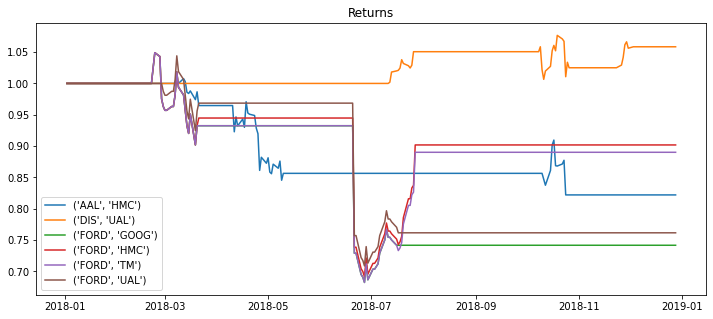

In [39]:
plt.figure(figsize=(12, 5))
for p in pairs:
    stock_data_adjusted = stock_data['Adj Close']
    pair_backtest = Pairs(stock_data_adjusted[list(p)])
    pair = pair_backtest.run_backtest()
    plt.title ('Returns')
    plt.plot(pair.returns, label=p)
    plt.legend();

# Step 4: Reflect on how to improve

The set of stocks I have pickekd for the PCW contains airline companies, car manifacturers, and tech companies. Most of the pairs don't seem to perform well in terms of return except for the pair of Disney and United Airlines.

